In [115]:
using SymbolicNumericIntegration
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers
using DoubleFloats
using JLD
using LaTeXStrings

In [2]:
@variables x y;
dx(exprs) = simplify(expand_derivatives(Differential(x)(exprs)))
dy(exprs) = simplify(expand_derivatives(Differential(y)(exprs)))
u = -y*sin(x^2 + y^2)
v = x*sin(x^2 + y^2)
p = sin(x-y)
#u = 20*x*y^3
#v = 5*x^4 - 5*y^4
#p = 60*x*x*y - 20*y*y*y 
f1 = -dx(dx(u)) - dy(dy(u)) + dx(p)
f2 = -dx(dx(v)) - dy(dy(v)) + dy(p)
display(f1)
display(f2)
f1 = eval(build_function(f1,x,y))
f2 = eval(build_function(f2,x,y))
true_v1 = eval(build_function(u,x,y))
true_v2 = eval(build_function(v,x,y))

8y*cos(x^2 + y^2) + cos(x - y) - 4(y^3)*sin(x^2 + y^2) - 4y*(x^2)*sin(x^2 + y^2)

4(x^3)*sin(x^2 + y^2) + 4x*(y^2)*sin(x^2 + y^2) - cos(x - y) - 8x*cos(x^2 + y^2)

#20 (generic function with 1 method)

In [3]:
D = ones(Num,(6,6))
Z = zeros(Num,(6,6))
Z[1,1] = x^(5//2)
Z[2,2] = x^(5//2)
Z[3,3] = x^(1//2)
Z[4,4] = x^(1//2)
Z[5,5] = x^(5//2)
Z[6,6] = x^(5//2)
Z*D*Z

6×6 Matrix{Num}:
 x^(5//1)  x^(5//1)  x^(3//1)  x^(3//1)  x^(5//1)  x^(5//1)
 x^(5//1)  x^(5//1)  x^(3//1)  x^(3//1)  x^(5//1)  x^(5//1)
 x^(3//1)  x^(3//1)         x         x  x^(3//1)  x^(3//1)
 x^(3//1)  x^(3//1)         x         x  x^(3//1)  x^(3//1)
 x^(5//1)  x^(5//1)  x^(3//1)  x^(3//1)  x^(5//1)  x^(5//1)
 x^(5//1)  x^(5//1)  x^(3//1)  x^(3//1)  x^(5//1)  x^(5//1)

In [96]:
@variables ϵ r x₁ x₂ ;
μ = 1.0
ρ = 1.0
#ϕ2 = exp(-r^2*ϵ^2)
#ϕ = (1.0-r*ϵ)^8 * (32.0*(r*ϵ)^3 + 25.0* (r*ϵ)^2 + 8.0*r*ϵ + 1.0)
ϕ = (1-r*ϵ)^10 * (429*(r*ϵ)^4 + 450*(r*ϵ)^3 + 210*(r*ϵ)^2 + 50*(r*ϵ)+5)
ϕ2 = copy(ϕ)
#ϕ = (ϵ*r)^7
#ϕ2 =(ϵ*r)^3
#ϕ = (1-r*ϵ)^4 * (4r*ϵ+1)
ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2)) 
ϕ2 = substitute(ϕ2, r=>sqrt(x₁^2 + x₂^2)) 
#ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2))
ϕ = simplify(ϕ,expand = true)
ϕ2 = simplify(ϕ2,expand = true)
display(ϕ)  
#Δ(exprs) = expand_derivatives((Differential(x₁)^2)(exprs) + (Differential(x₂)^2)(exprs))
#∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)) + expand_derivatives(Differential(r)(exprs)) * (x₁/r),expand = true)
#∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)) + expand_derivatives(Differential(r)(exprs)) * (x₂/r),expand = true)
∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)))
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)))
Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))


Φ_div = ([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)) 0; ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ)) 0; 0 0 ϕ2])
Φ_div = substitute.(Φ_div,r=>sqrt(x₁^2 + x₂^2))


λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ1y(x) = -(μ/ρ)*Δ(x[1]) -  (1/ρ)*∂₁(x[3]) #- ∂₁(x[1]) - ∂₂(x[1])
λ2y(x) = -(μ/ρ)*Δ(x[2]) -  (1/ρ)*∂₂(x[3]) #- ∂₁(x[2]) - ∂₂(x[2])
λ3y(x) = x[1]
λ4y(x) = x[2]

λ1x(x) = -(μ/ρ)*Δ(x[1]) + (1/ρ)*∂₁(x[3]) #+ ∂₁(x[1]) + ∂₂(x[1])
λ2x(x) = -(μ/ρ)*Δ(x[2]) +  (1/ρ)*∂₂(x[3]) #+ ∂₁(x[2]) + ∂₂(x[2])
λ3x(x) = x[1]
λ4x(x) = x[2]

display(Φ_div)



(5//1) + (429//1)*(ϵ^4)*(sqrt(x₁^2 + x₂^2)^4) + (15015//1)*(ϵ^8)*(sqrt(x₁^2 + x₂^2)^8) + (15015//1)*(ϵ^12)*(sqrt(x₁^2 + x₂^2)^12) + (45045//1)*(ϵ^10)*(sqrt(x₁^2 + x₂^2)^10) + (429//1)*(ϵ^14)*(sqrt(x₁^2 + x₂^2)^14) - (65//1)*(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2) - (2145//1)*(ϵ^6)*(sqrt(x₁^2 + x₂^2)^6) - (33280//1)*(ϵ^11)*(sqrt(x₁^2 + x₂^2)^11) - (36608//1)*(ϵ^9)*(sqrt(x₁^2 + x₂^2)^9) - (3840//1)*(ϵ^13)*(sqrt(x₁^2 + x₂^2)^13)

3×3 Matrix{Num}:
 (130//1)*(ϵ^2) + (12870//1)*(ϵ^6)*(sqrt(x₁^2 + x₂^2)^4) + (49920//1)*(ϵ^13)*(sqrt(x₁^2 + x₂^2)^11) + (329472//1)*(ϵ^9)*(sqrt(x₁^2 + x₂^2)^7) + (366080//1)*(ϵ^11)*(sqrt(x₁^2 + x₂^2)^9) + (51480//1)*(x₂^2)*(ϵ^6)*(sqrt(x₁^2 + x₂^2)^2) + (549120//1)*(x₂^2)*(ϵ^13)*(sqrt(x₁^2 + x₂^2)^9) + (2306304//1)*(x₂^2)*(ϵ^9)*(sqrt(x₁^2 + x₂^2)^5) + (3294720//1)*(x₂^2)*(ϵ^11)*(sqrt(x₁^2 + x₂^2)^7) - (3432//1)*(x₂^2)*(ϵ^4) - (1716//1)*(ϵ^4)*(sqrt(x₁^2 + x₂^2)^2) - (6006//1)*(ϵ^14)*(sqrt(x₁^2 + x₂^2)^12) - (120120//1)*(ϵ^8)*(sqrt(x₁^2 + x₂^2)^6) - (450450//1)*(ϵ^10)*(sqrt(x₁^2 + x₂^2)^8) - (180180//1)*(ϵ^12)*(sqrt(x₁^2 + x₂^2)^10) - (720720//1)*(x₂^2)*(ϵ^8)*(sqrt(x₁^2 + x₂^2)^4) - (1801800//1)*(x₂^2)*(ϵ^12)*(sqrt(x₁^2 + x₂^2)^8) - (72072//1)*(x₂^2)*(ϵ^14)*(sqrt(x₁^2 + x₂^2)^10) - (3603600//1)*(x₂^2)*(ϵ^10)*(sqrt(x₁^2 + x₂^2)^6)  …                                                                                                                                                                

In [97]:
K = construct_kernel_array(Φ_div,[λ1x,λ2x,λ3x,λ4x],[λ1y,λ2y,λ3y,λ4y])
display(K)
#K = substitute.(K, sqrt(x₁^2+x₂^2) => r)
#K = substitute.(K, (Dict([x₁ => r, x₂ =>r]),))
#display(K)
K = compile_kernel_array(K)

KE = construct_kernel_array(Φ_div,[λu,λv,λp],[λ1y,λ2y,λ3y,λ4y])
#display(KE)
KE = compile_kernel_array(KE)


#println(K[1,1]([1e-40,1e-40],1.0))
function generate_poly_basis(m,n)
    P_list = []
    P_list2D = generate_2D2_div_free_poly_basis(m)
    P_list1D = generate_2D1_poly_basis(n)
    for p2 in P_list2D
        append!(P_list, [vcat(p2,Num(0.0))])
    end
    for p1 in P_list1D[2:end]
        append!(P_list, [vcat(Num(0.0),Num(0.0),p1)])
    end
    return P_list
end


P_list = generate_poly_basis(4,2)


F_P = apply_functionals_to_polynomials([λ1x,λ2x,λ3x,λ4x],P_list)
display(F_P)
F_P = compile_polynomials(F_P)

F_PE = apply_functionals_to_polynomials([λu,λv,λp],P_list)
#display(F_PE)
F_PE = compile_polynomials(F_PE)

N_poly = size(F_P)[2]


#display(P_list2D)

#display(substitute.(K, x₁=>r ))

4×4 Matrix{Num}:
 (130//1)*(ϵ^2) + 2.47104e6(ϵ^6) + (12870//1)*(ϵ^6)*(sqrt(x₁^2 + x₂^2)^4) + (49920//1)*(ϵ^13)*(sqrt(x₁^2 + x₂^2)^11) + 2.76756e8(ϵ^9)*(sqrt(x₁^2 + x₂^2)^3) + (329472//1)*(ϵ^9)*(sqrt(x₁^2 + x₂^2)^7) + (366080//1)*(ϵ^11)*(sqrt(x₁^2 + x₂^2)^9) + 5.53513e8(ϵ^11)*(sqrt(x₁^2 + x₂^2)^5) + 1.1861e8(ϵ^13)*(sqrt(x₁^2 + x₂^2)^7) + 3.45946e8(x₁^4)*(ϵ^11)*sqrt(x₁^2 + x₂^2) + 3.45946e7(x₁^4)*(ϵ^9)*(sqrt(x₁^2 + x₂^2)^-1) + (51480//1)*(x₁^2)*(ϵ^6)*(sqrt(x₁^2 + x₂^2)^2) + 5.88108e9(x₂^4)*(ϵ^11)*sqrt(x₁^2 + x₂^2) + 1.72973e8(x₁^4)*(ϵ^13)*(sqrt(x₁^2 + x₂^2)^3) + 2.94054e9(x₂^4)*(ϵ^13)*(sqrt(x₁^2 + x₂^2)^3) + (549120//1)*(x₁^2)*(ϵ^13)*(sqrt(x₁^2 + x₂^2)^9) + 5.88108e8(x₂^4)*(ϵ^9)*(sqrt(x₁^2 + x₂^2)^-1) + (2306304//1)*(x₁^2)*(ϵ^9)*(sqrt(x₁^2 + x₂^2)^5) + 4.15135e8(x₁^2)*(ϵ^13)*(sqrt(x₁^2 + x₂^2)^5) + 4.15135e8(x₁^2)*(ϵ^9)*sqrt(x₁^2 + x₂^2) + 2.07567e9(x₂^2)*(ϵ^9)*sqrt(x₁^2 + x₂^2) + 3.45946e8(x₂^6)*(ϵ^11)*(sqrt(x₁^2 + x₂^2)^-1) + (3294720//1)*(x₁^2)*(ϵ^11)*(sqrt(x₁^2 + x₂^2)^7) + 1.38378e9

4×25 Matrix{Num}:
 0.0   0.0    0.0    -2.0               0.0  …  0.0  1.0    0.0  x₂    2x₁
 0.0   0.0    0.0     0.0               1.0     1.0  0.0  2x₂    x₁      0.0
 1    x₂     x₁    x₂^2             x₁*x₂       0.0  0.0    0.0   0.0    0.0
 0.0   0.0  -x₂       0.0  (-1//2)*(x₂^2)       0.0  0.0    0.0   0.0    0.0

25

done(825,)

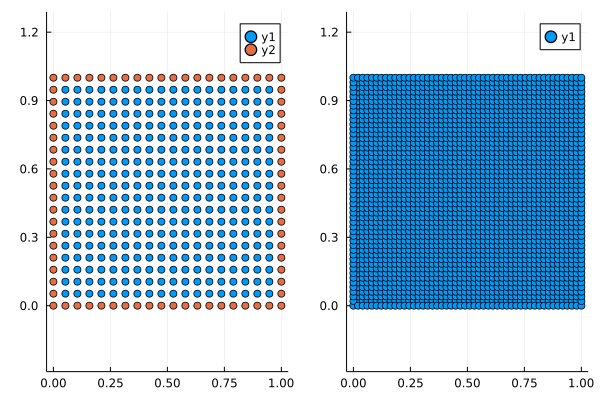

In [36]:

N_coll = 20

I_points,B_points = generate_2D_equally_spaced_points(N_coll) 

N_I = size(I_points)[2]
N_B = size(B_points)[2]
All_points = hcat(I_points,B_points)
All_points = All_points
Test_points = generate_2D_Halton_points(3000)
Test_points = hcat(generate_2D_equally_spaced_points(50)...)
N_tot = size(All_points)[2]
N_test = size(Test_points)[2]

f = vcat(f1.(I_points[1,:],I_points[2,:]),f2.(I_points[1,:],I_points[2,:]))
g = vcat(true_v1.(B_points[1,:],B_points[2,:]),true_v2.(B_points[1,:],B_points[2,:]))
b = vcat(f,g,zeros(N_poly))

reference_v = vcat(true_v1.(Test_points[1,:],Test_points[2,:]),true_v2.(Test_points[1,:],Test_points[2,:]))
print("done",size(b))

l = @layout [a b]
p1 = scatter(I_points[1,:], I_points[2,:],aspect_ratio = :equal)
p1 = scatter!(B_points[1,:], B_points[2,:])

p2 = scatter(Test_points[1,:], Test_points[2,:],aspect_ratio = :equal)


plot(p1, p2 ,layout = l)

In [98]:
function batch_solve(n_lst,K,KE,F_P,F_PE,param)
    N_test = 2000
    Test_points = generate_2D_Halton_points(N_test)
    
    N_poly = size(F_P)[2]
    cond_lst = []
    Max_error_lst = []
    for n in n_lst
        I_points,B_points = generate_2D_equally_spaced_points(n)
        f = vcat(f1.(I_points[1,:],I_points[2,:]),f2.(I_points[1,:],I_points[2,:]))
        b = vcat(true_v1.(B_points[1,:],B_points[2,:]),true_v2.(B_points[1,:],B_points[2,:]))
        b = vcat(f,b,zeros(N_poly))
        reference_v = vcat(true_v1.(Test_points[1,:],Test_points[2,:]),true_v2.(Test_points[1,:],Test_points[2,:]))

        A = crete_block_point_tensors([I_points,I_points,B_points,B_points],[I_points,I_points,B_points,B_points])
        A = generate_block_matrices(K,A,param)
        A = flatten(A)
        E = crete_block_point_tensors([Test_points,Test_points,Test_points],[I_points,I_points,B_points,B_points])
        E = generate_block_matrices(KE,E,param)
        E = flatten(E)
        O = zeros(N_poly,N_poly)
        P = generate_P_matrix([I_points,I_points,B_points,B_points],F_P)
        PE = generate_P_matrix([Test_points,Test_points,Test_points],F_PE)
        M = [A P;P' O]
        Q = [E PE]

        #println("cond A: ",cond(A))
        #println("cond M: ",cond(M))
        M = Double64.(M)
        b = Double64.(b)

        c = M\b
        sol = Q*c
        sol = Float64.(sol)
        err_u = abs.(reference_v - sol[1:2*N_test])
        #L2_error = sqrt(sum(err_u .^2))
        max_error = maximum(err_u)
        #append!(L2_error_lst,[L2_error])
        append!(Max_error_lst,[max_error])
        append!(cond_lst,[cond(M)])
    end
    return  Max_error_lst, cond_lst
end

batch_solve (generic function with 1 method)

In [99]:
param = 0.1
A = crete_block_point_tensors([I_points,I_points,B_points,B_points],[I_points,I_points,B_points,B_points])
A = generate_block_matrices(K,A,param)
A = flatten(A)

E = crete_block_point_tensors([Test_points,Test_points,Test_points],[I_points,I_points,B_points,B_points])
E = generate_block_matrices(KE,E,param)
E = flatten(E)
#display(E)

O = zeros(N_poly,N_poly)
P = generate_P_matrix([I_points,I_points,B_points,B_points],F_P)
PE = generate_P_matrix([Test_points,Test_points,Test_points],F_PE)
M = [A P
    P' O]

Q = [E PE]

println("cond A: ",cond(A))
println("cond M: ",cond(M))


cond A: 4.1801502819464905e15
cond M: 4.1866203108816245e15


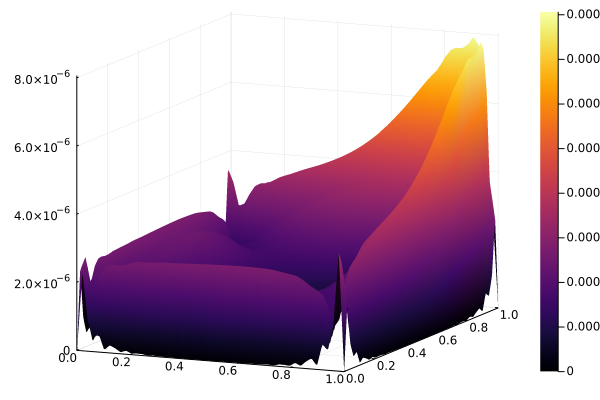

In [100]:
M = Double64.(M)
Q = Double64.(Q)
c = inv(M)*b
sol = Float64.(Q*c)
#c = Float64.(A)\vcat(f,g)
#sol = Float64.(E*c)
err = (abs.(sol[1:2N_test] .- reference_v))
#scatter(Test_points[1,:],Test_points[2,:],err)
maximum(err)
surface(Test_points[1,:],Test_points[2,:],sqrt.(err[1:N_test] .^2 + err[1+N_test:2N_test] .^2))

In [9]:
#errR7R3P3P1 = [0.01083701445629664,0.011040613912115341,0.00852847962855357, 0.006185110581584295, 0.004483644472723684, 0.0032861939356198596, 0.0024476447268578683]
#errR7R3P4P1 = [0.6003512257000744,0.6115595214891938,0.5466580059126647,0.4553585209884193,0.3644741418608427,0.2872247379379661,0.22666347617101978]
#errR7R3P4P2 = [0.02712897417077472,0.04214232804255723,0.0504524529487916,0.05092690694644397,0.046882703437921856,0.041731996789498016,0.03701355732902488]

#plot([10,15,20,25,30,35,40] .^ -1 ,aaa,yscale =:log10,xscale =:log10)

anss = batch_solve([5,10,20,30],K,KE,F_P,F_PE,param)


(Any[0.002256351495483977, 0.00013395536834792665, 8.240478961973885e-6, 1.5542870618334703e-6], Any[1.38909293110041945647450591362944799e+09, 2.7697591136084425093751453656507164e+12, 4.18873537859029662952844563601961791e+15, 2.55557963649103925896473144676225076e+17])

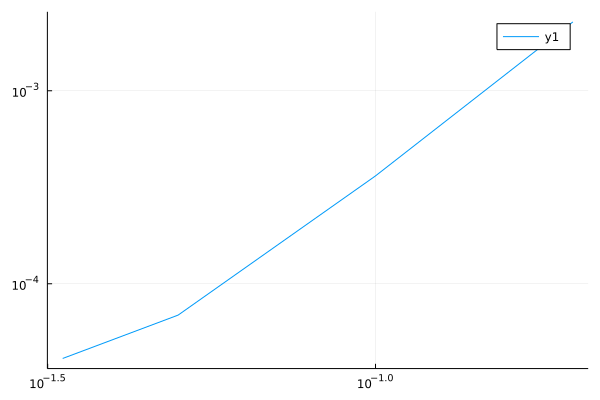

In [15]:
plot([5,10,20,30] .^-1, anss[1], xscale = :log10,yscale = :log10,)

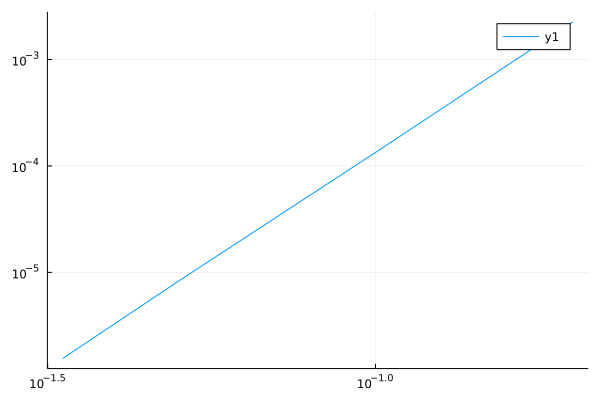

In [10]:
plot([5,10,20,30] .^-1, anss2[1], xscale = :log10,yscale = :log10,)

In [101]:

F_P_list = []
F_PE_list = []
for i in [1,2,3,4]
    append!(F_P_list,[compile_polynomials(apply_functionals_to_polynomials([λ1x,λ2x,λ3x,λ4x],generate_poly_basis(i,i)))])
    append!(F_PE_list,[compile_polynomials(apply_functionals_to_polynomials([λu,λv,λp],generate_poly_basis(i,i)))])
end
println("done compiling")
fill_dist_lst = [10,15,20,25,30]
N_data = length(fill_dist_lst)
# ϵ, polynomial degree, number of points along aech axis
Err_tensor = zeros(4,N_data)
cond_tensor = zeros(4,N_data)
progress = 0

for j in 1:4
    F_P = F_P_list[j]
    F_PE = F_PE_list[j]
    err_array,cond_num_array = batch_solve(fill_dist_lst,K,KE,F_P,F_PE,0.1)
    Err_tensor[j,:]  = err_array
    cond_tensor[j,:]  = cond_num_array
    #println(ϵ)
end



done compiling


In [124]:
#Err_tensor
#JLD.save("saved_benchmarks/sdsdsdsd.jld", "error", Err_tensor, "condition", cond_tensor, "N",fill_dist_lst, "poly",[1,2,3,4])
d_polyharm = load("saved_benchmarks/polyharm_7_3_.jld")
d_wendland = load("saved_benchmarks/Wendlands_C10.jld")
display(d)
Err_polyharm = d_polyharm["error"]
cond_polyharm = d_polyharm["condition"]
fill_dist_lst = d_polyharm["N"]
Err_wendland = d_wendland["error"]
cond_wendland = d_wendland["condition"]

Dict{String, Any} with 4 entries:
  "error"     => [0.000549631 0.000129508 … 5.41353e-5 4.01868e-5; 0.00067372 0…
  "N"         => [10, 15, 20, 25, 30]
  "poly"      => [1, 2, 3, 4]
  "condition" => [9.2251e9 3.0278e11 … 1.91439e13 8.00434e13; 9.2201e9 3.02661e…

4×5 Matrix{Float64}:
 2.59831e12  2.00897e14  4.17865e15  4.02124e16  2.56215e17
 2.6246e12   2.01763e14  4.18845e15  4.02693e16  2.56452e17
 2.57996e12  1.97153e14  4.10702e15  3.96561e16  2.53302e17
 2.68058e12  2.02663e14  4.17244e15  4.0052e16   2.54968e17

In [123]:

shapes = [:square,:star5,:circle,:hexagon]
plot(label = "q")
for i in 1:4
    plot!(fill_dist_lst .^-1, Err_polyharm[i,:],scale = :log10, label = false,linestyle = :dash)
    scatter!(fill_dist_lst .^-1, Err_polyharm[i,:],scale = :log10,label = "m = n = "*string(i),markershape = shapes[i])

    plot!(fill_dist_lst .^-1, Err_wendland[i,:],scale = :log10, label = false,linestyle = :solid)
    scatter!(fill_dist_lst .^-1, Err_wendland[i,:],scale = :log10,label = false,markershape = shapes[i])
end
plot!([0.1],[0.0001],label = "Polyharmonics",linestyle = :dash)
plot!([0.1],[0.0001],label = "Wendland C8",linestyle = :solid)
plot!(legend = :bottomright,xlabel = L"h",ylabel = L"{||e||}_{\infty}")
savefig("report_figures/wendland_vs_polyharmonics.png")

In [135]:
colors = [:brown, :green, :blue, :orange]
shapes = [:square,:star5,:circle,:hexagon]
plot(label = "q")
for i in 1:4
    plot!(cond_polyharm[i,:], Err_polyharm[i,:],scale = :log10, label = false,linestyle = :dash,color = colors[i])
    scatter!(cond_polyharm[i,:], Err_polyharm[i,:],scale = :log10,label = "m = n = "*string(i),markershape = shapes[i],color = colors[i])

    plot!(cond_wendland[i,:], Err_wendland[i,:],scale = :log10, label = false,linestyle = :solid,color = colors[i])
    scatter!(cond_wendland[i,:], Err_wendland[i,:],scale = :log10,label = false,markershape = shapes[i],color = colors[i])
end
plot!([10^12],[0.0001],label = "Polyharmonics",linestyle = :dash)
plot!([10^12],[0.0001],label = "Wendland C8",linestyle = :solid)
plot!(legend = :topright,xlabel = "condition number",ylabel = L"{||e||}_{\infty}")
savefig("report_figures/wendland_vs_polyharmonics_condition.png")